In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from disp import set_font_size

cc = np.concatenate

FPS = 30.03
LAG = 30
ILAG = int(np.round(LAG*FPS))

NTR_USE = 276
NEPOCH = 10

KTARG = 'FFV'

In [2]:
# STACK = nn.Sequential(nn.Linear(2*ILAG, 1),)
STACK = nn.Sequential(nn.Linear(2*ILAG, 1), nn.ReLU(),)
# STACK = nn.Sequential(nn.Linear(2*ILAG, 1000), nn.ReLU(), nn.Linear(1000, 1))
# STACK = nn.Sequential(nn.Linear(2*ILAG, 100), nn.ReLU(), nn.Linear(100, 25), nn.ReLU(), nn.Linear(25, 1), nn.ReLU(),)

In [3]:
df = pd.read_csv('data/simple/c_song_f_behav.csv')

ntr = np.max(df.ID) + 1
dfs = [df[df.ID == i] for i in range(ntr)]

df = None

In [4]:
# write Dataset and DataLoader classes for song data
class SongBehavDataset(Dataset):
    """Class for handling song + behavioral datasets."""
    
    def __init__(self, itrs, ktarg, lag, fps):
        self.itrs = itrs
        self.dfs = np.array(dfs, dtype=object)[itrs]
        self.tr_lens = np.array([len(df) for df in self.dfs])
        self.tr_lens_cum = self.tr_lens.cumsum()
        self.ntr = len(self.tr_lens)
        
        self.ktarg = ktarg
        
        self.lag = lag  # lag in seconds
        self.fps = fps
        self.ilag = int(np.round(lag*self.fps))  # lag in timesteps
        
    def __len__(self):
        # number of diff datapoints is sum of valid timepoints across trials
        return self.tr_lens.sum()
    
    def __getitem__(self, idx):
        itr = np.sum(self.tr_lens_cum <= idx)
        it = idx if itr == 0 else idx - self.tr_lens_cum[itr-1]
        
        if it < self.ilag:
            x = cc([np.zeros((self.ilag-it, 2)), np.array(self.dfs[itr][['S', 'P']])[:it]], axis=0)  
        else:
            x = np.array(self.dfs[itr][['S', 'P']])[it-self.ilag:it, :]
           
        y = np.array(self.dfs[itr][self.ktarg])[it]
        return x.T.flatten(), np.array([y])
    
    @property
    def targs(self):
        return [np.array(df[self.ktarg]) for df in self.dfs]

In [5]:
ntrain = int(np.round(.8 * NTR_USE))
ntest = NTR_USE - ntrain
perm = np.random.permutation(ntr)
train_idx = perm[:ntrain]
test_idx = perm[ntrain:ntrain+ntest]

fly_data_train = SongBehavDataset(train_idx, KTARG, LAG, FPS)
fly_data_test = SongBehavDataset(test_idx, KTARG, LAG, FPS)

In [6]:
# make data loaders
train_dataloader = DataLoader(fly_data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(fly_data_test, batch_size=64, shuffle=True)

In [7]:
for x, y in train_dataloader:
    print('Shape of x:', x.shape)
    print('Shape of y:', y.shape)
    break

RuntimeError: Expected object of scalar type Long but got scalar type Double for sequence element 15 in sequence argument at position #1 'tensors'

In [8]:
# set up network model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = STACK
        
    def forward(self, x):
        x = self.flatten(x)
        pred = self.layer_stack(x)
        return pred

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=1802, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        # compute prediction error
        pred = model(x.float())
        loss = loss_fn(pred, y.float())
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose and (batch % 1000 == 0):
            loss, current = loss.item(), batch * len(x)
            print(f'Train loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x.float())
            test_loss += loss_fn(pred, y.float()).item()
            
        test_loss /= num_batches
        print(f'Avg test loss: {test_loss:>8f}')

In [11]:
for cepoch in range(NEPOCH):
    print(f'Epoch {cepoch+1}\n--------------')
    train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------
Train loss: 0.052777 [    0/3900423]
Train loss: 0.056189 [64000/3900423]
Train loss: 0.037341 [128000/3900423]


KeyboardInterrupt: 

In [12]:
nplt = 5
fly_data_plot = SongBehavDataset(test_idx[:5], KTARG, LAG, FPS)
plot_dataloader = DataLoader(fly_data_plot, batch_size=1000, shuffle=False)

model.eval()

f_behav_true = cc([y for x, y in plot_dataloader])
f_behav_pred = torch.cat([model(x.float()) for x, y in plot_dataloader]).detach().numpy()

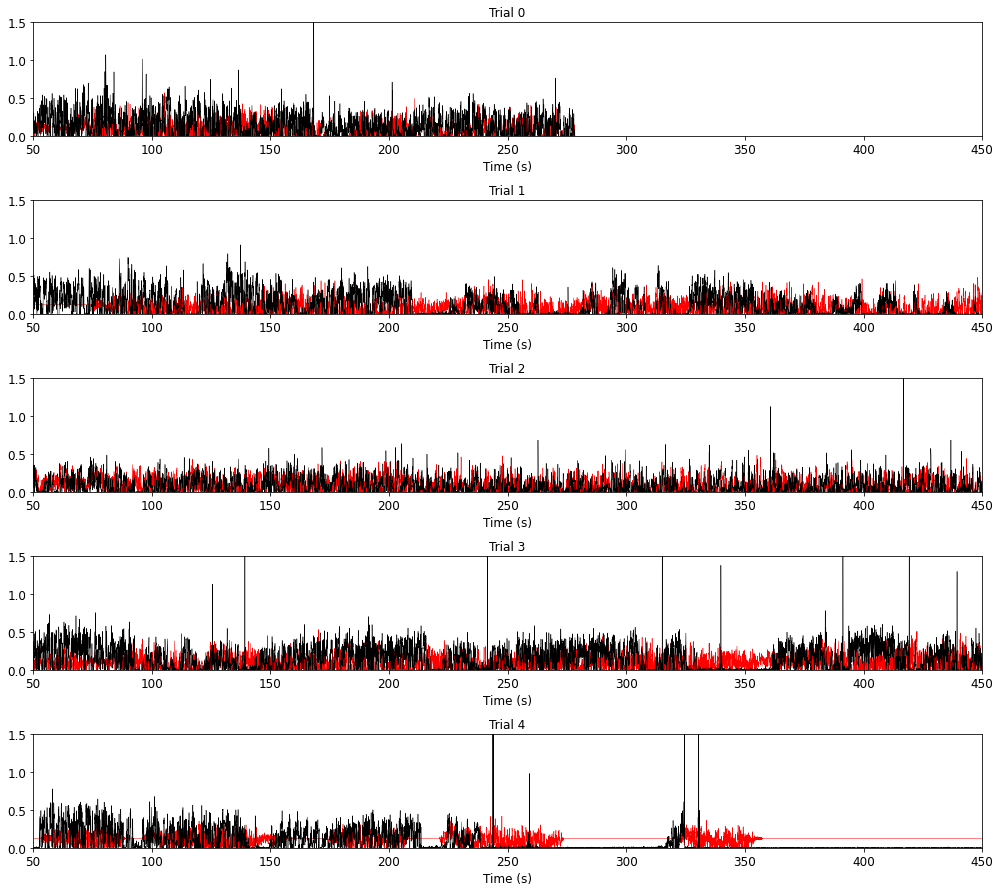

In [18]:
trs_xpl = np.arange(nplt)
fig, axs = plt.subplots(nplt, 1, figsize=(14, nplt*2.5), tight_layout=True)
for ctr, ax in enumerate(axs):
    istart, istop = cc([[0], fly_data_plot.tr_lens_cum])[[ctr, ctr+1]]
    t = np.arange(istop-istart)/FPS
    ax.plot(t, f_behav_pred[istart:istop], c='r', lw=.5)
    ax.plot(t, f_behav_true[istart:istop], c='k', lw=.5)
    
    ax.set_xlim(50, 450)
    ax.set_ylim(0, 1.5)
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Trial {trs_xpl[ctr]}')
    
set_font_size(axs, 12)

In [14]:
# compute total test set R^2
r2_dataloader = DataLoader(fly_data_test, batch_size=10000, shuffle=False)

f_behav_pred = torch.cat([model(x.float()) for x, y in r2_dataloader]).detach().numpy()

In [15]:
targs = cc(fly_data_test.targs)
r2 = stats.linregress(f_behav_pred.flatten(), targs)[2]**2
print('Test R2 = ', r2)

Test R2 =  0.012978240213656464
